In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


## 1. Data Collection

### 1.1 Importing Necessary Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

### 1.2 Loading Datasets
#### It's essential first to visualize the **top rows** of the dataset to understand its structure. We can identify column names, data types, and general content.

In [3]:
train_data = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv",index_col = 0)
train_data.head()


,Date,Open,Close,Volume,Strategy
id,,,,,
0,2015-06-01,66.208486,75.609978,298506300,Hold
1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2015-06-15,47.701942,71.140831,250670900,Buy
3,2015-06-22,54.754816,72.881344,223614300,Hold
4,2015-06-29,48.031899,66.284718,406814900,Buy


In [4]:
test_data = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv", index_col = 0)
test_data.head()

,Date,Open,Volume
id,,,
0,2021-03-01,72.708331,205897600
1,2021-03-08,73.310886,214095600
2,2021-03-15,70.610119,151601700
3,2021-03-22,70.256017,193982500
4,2021-03-29,68.258324,220238400


### 1.3 Checking for missing values

In [5]:
missing_count = train_data.isnull().sum()
missing_percentage = (train_data.isnull().sum() / len(train_data)) * 100
missing_data = pd.DataFrame({'Count': missing_count, 'Percentage': missing_percentage})
print(missing_data[missing_data['Count'] > 0])

missing_count2 = test_data.isnull().sum()
missing_percentage2 = (test_data.isnull().sum() / len(test_data)) * 100
missing_data2 = pd.DataFrame({'Count': missing_count, 'Percentage': missing_percentage})
print(missing_data2[missing_data2['Count'] > 0])

Empty DataFrame
Columns: [Count, Percentage]
Index: []
Empty DataFrame
Columns: [Count, Percentage]
Index: []


#### Dataset is complete, and there are no missing values to report.

### 1.4 Checking for outliers

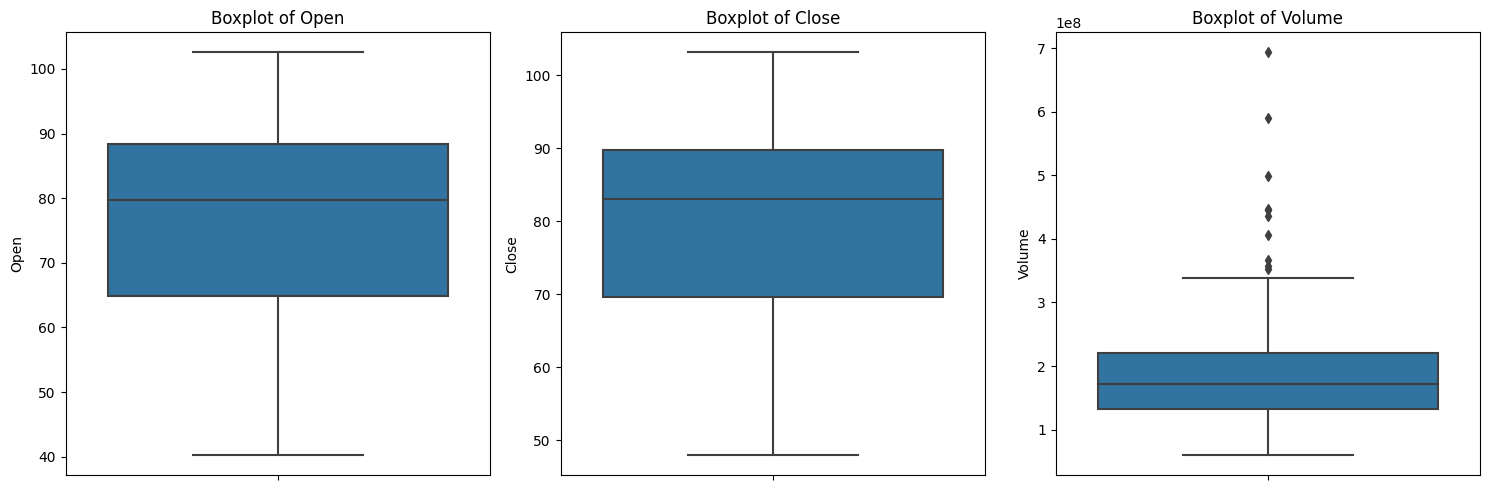

In [6]:
import matplotlib.pyplot as plt
numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=train_data, y=col, ax=axes[i])  
    axes[i].set_title(f"Boxplot of {col}")
plt.tight_layout() 
plt.show()

    
#### There are multiple dots or points above the top whisker, representing outlier values. These indicate that there were certain days/times when the trading volume was significantly higher than typical.

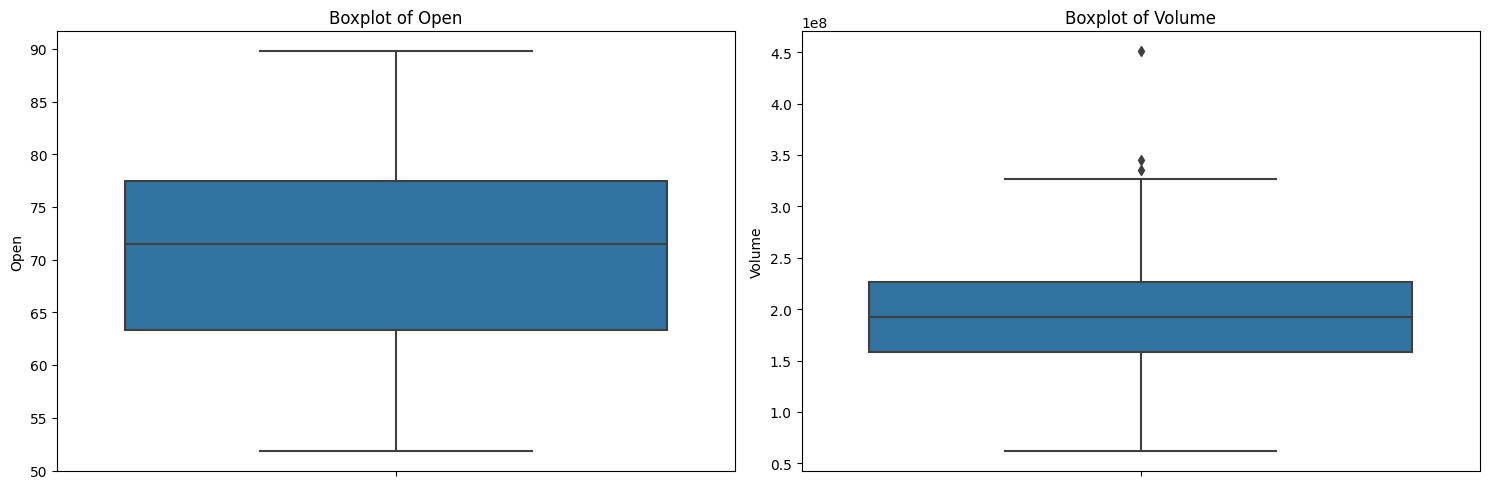

In [7]:
numeric_cols = test_data.select_dtypes(include=['float64', 'int64']).columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=test_data, y=col, ax=axes[i])  
    axes[i].set_title(f"Boxplot of {col}")
plt.tight_layout() 
plt.show()

## 2. DATA PREPROCESSING

### 2.1 Removing outliers for 'Volume'

#### We will not be removing any outliers here as they might hold a significant value during a particular peak or low state but let's see how the outliers can be removed.

In [8]:
Q1 = train_data['Volume'].quantile(0.25)
Q3 = train_data['Volume'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = train_data[(train_data['Volume'] >= lower_bound) & (train_data['Volume'] <= upper_bound)]


#### High trading volumes can be associated with significant market crashes, major company announcements, or other factors that could have driven a large number of trades -> valuable information about the stock's behavior during those times, whereas if we're interested in the typical behavior of the stock, these outliers might introduce noise.

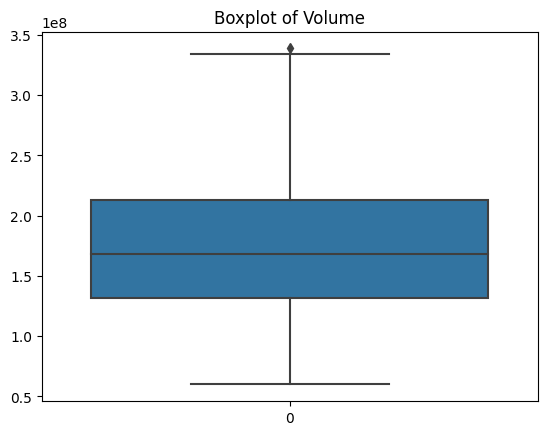

In [9]:
sns.boxplot(filtered_data['Volume'])
plt.title("Boxplot of Volume")
plt.show()

In [10]:
Q1 = test_data['Volume'].quantile(0.25)
Q3 = test_data['Volume'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data2 = test_data[(test_data['Volume'] >= lower_bound) & (test_data['Volume'] <= upper_bound)]

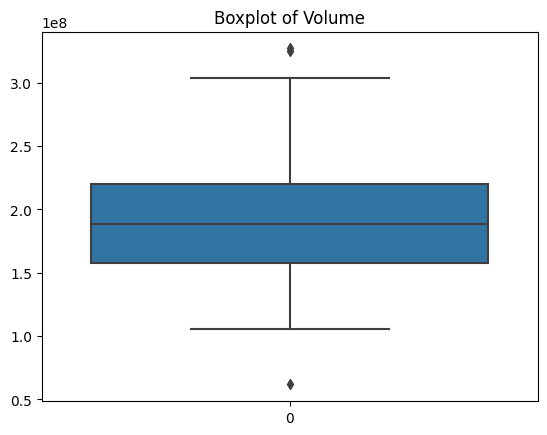

In [11]:
sns.boxplot(filtered_data2['Volume'])
plt.title("Boxplot of Volume")
plt.show()

#### 2.2 Convert time-related columns into datetime format if they aren't already.

In [12]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

#### 2.3 Scaling ensures each feature has equal weight, initially -> we will not be doing this as the absolute values have meaning.

## 3. Exploratory Data Analysis (EDA)

### 3.1 Time Series Plot

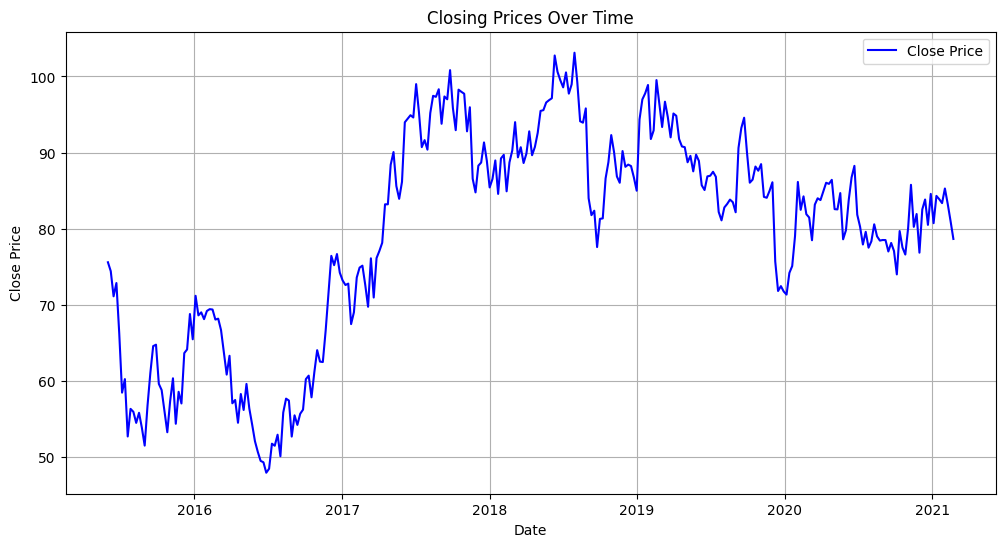

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

train_data = train_data.sort_values(by='Date')

# Create a time series plot for the closing prices
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Close Price', color='blue')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.show()

#### The time series plot displays the closing prices from 2016 to 2021. It shows an upward trend from mid-2016 to early 2018, with notable volatility post-2018.

### 3.2 Data Summary

In [14]:
data_summary = train_data.describe()
print(data_summary)

                      Date        Open       Close        Volume
count                  300  300.000000  300.000000  3.000000e+02
mean   2018-04-12 12:00:00   75.977813   79.430489  1.866300e+08
min    2015-06-01 00:00:00   40.269435   47.979353  5.991330e+07
25%    2016-11-05 06:00:00   64.872395   69.689227  1.324862e+08
50%    2018-04-12 12:00:00   79.805683   82.991900  1.715536e+08
75%    2019-09-17 18:00:00   88.342927   89.719145  2.201842e+08
max    2021-02-22 00:00:00  102.558322  103.119373  6.935702e+08
std                    NaN   16.158343   13.878395  7.952792e+07


#### The data provides insights into the opening and closing prices of a certain financial instrument or stock, as well as its trading volume, over a specified period. The prices have shown fluctuations, as indicated by the standard deviation, and the volume has varied considerably as well.

### 3.2 Data Distribution plots

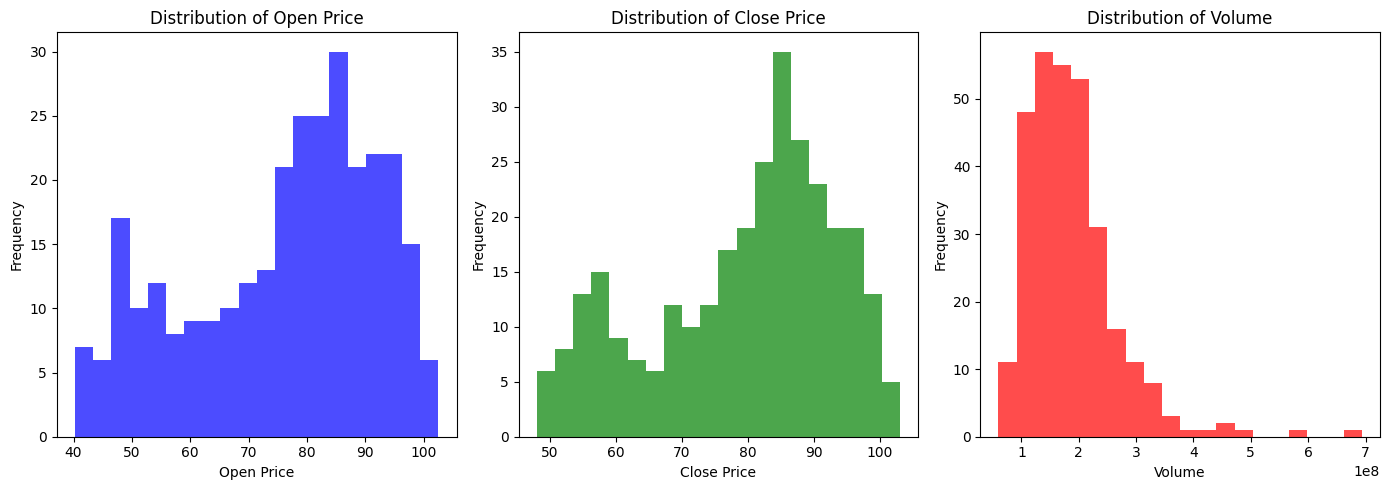

In [15]:
# Plot data distribution for numerical columns
plt.figure(figsize=(14, 5))

# Plot histograms for 'Open,' 'Close,' and 'Volume'
plt.subplot(131)
plt.hist(train_data['Open'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Open Price')
plt.xlabel('Open Price')
plt.ylabel('Frequency')

plt.subplot(132)
plt.hist(train_data['Close'], bins=20, color='green', alpha=0.7)
plt.title('Distribution of Close Price')
plt.xlabel('Close Price')
plt.ylabel('Frequency')

plt.subplot(133)
plt.hist(train_data['Volume'], bins=20, color='red', alpha=0.7)
plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### The histograms display the distribution of Open Price, Close Price, and Volume:

1. Open Price: Most frequently falls in the range of approximately 70 to 90.
2. Close Price: Peaks around 70 to 80.
3. Volume: Predominantly lies between 1e8 to 4e8 with a sharp decrease thereafter.

### 3.3 Hypothesis Testing

In [16]:
from scipy.stats import shapiro
# Extract the 'Close' prices
close_prices = train_data['Close']

# Perform the Shapiro-Wilk test for normality
statistic, p_value = shapiro(close_prices)

# Set the significance level
alpha = 0.05

# Inference
if p_value > alpha:
    print("The 'Close' prices are normally distributed (fail to reject the null hypothesis).")
else:
    print("The 'Close' prices are not normally distributed (reject the null hypothesis).")

# Output the test statistic and p-value
print(f"Test Statistic: {statistic}")
print(f"P-Value: {p_value}")

The 'Close' prices are not normally distributed (reject the null hypothesis).
Test Statistic: 0.941137433052063
P-Value: 1.4571368556204334e-09


#### The Shapiro-Wilk test was conducted to check the normality of 'Close' prices. The result indicates that the 'Close' prices are not normally distributed with a Test Statistic of 0.9411 and a p-value close to 0.

### 3.4 Dimensionality Reduction

In [17]:
from sklearn.decomposition import PCA
features = train_data[['Open', 'Close', 'Volume']]

# Initialize PCA with the desired number of components
pca = PCA(n_components=2)

# Fit and transform the data
reduced_data = pca.fit_transform(features)
# Output the first few rows of the reduced data
print(reduced_data[:5])

[[ 1.11876288e+08 -3.86184626e+00]
 [ 4.13447877e+07  7.17960821e+00]
 [ 6.40408877e+07  1.90419545e+01]
 [ 3.69842877e+07  1.58694245e+01]
 [ 2.20184888e+08  2.68894183e+00]]


#### Principal Component Analysis (PCA) was applied to reduce the dimensionality of the 'Open', 'Close', and 'Volume' features. The data was transformed into 2 principal components. The displayed output shows the first few rows of the reduced data.

### 3.5 Pattern and Anamoly Detection


         Date       Open      Close     Volume Strategy  Cluster
id                                                              
0  2015-06-01  66.208486  75.609978  298506300     Hold        2
1  2015-06-08  64.116235  74.443331  227974800     Hold        2
2  2015-06-15  47.701942  71.140831  250670900      Buy        2
3  2015-06-22  54.754816  72.881344  223614300     Hold        2
4  2015-06-29  48.031899  66.284718  406814900      Buy        1


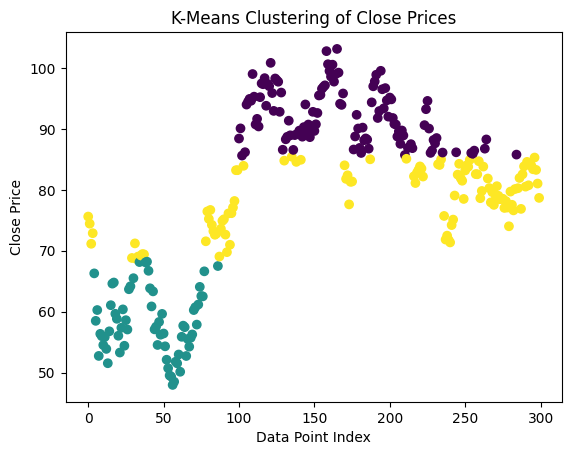

In [18]:
from sklearn.cluster import KMeans

feature_for_clustering = train_data[['Close']]

# Initialize K-Means with the desired number of clusters (e.g., 3) and set n_init explicitly
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)

# Fit the data to the K-Means model
train_data['Cluster'] = kmeans.fit_predict(feature_for_clustering)
# Output the first few rows of the data with cluster assignments
print(train_data.head())

# Visualize the clusters
plt.scatter(train_data.index, train_data['Close'], c=train_data['Cluster'], cmap='viridis')
plt.title('K-Means Clustering of Close Prices')
plt.xlabel('Data Point Index')
plt.ylabel('Close Price')
plt.show()

#### The K-Means clustering of 'Close Prices' has grouped the data into three distinct clusters, represented by different colors. The scatter plot shows the distribution of these clusters across the data point indices. The table snippet above provides a glimpse of the data, indicating the strategy ('Hold' or 'Buy') and associated cluster number for specific data points.

### 3.6 Plots

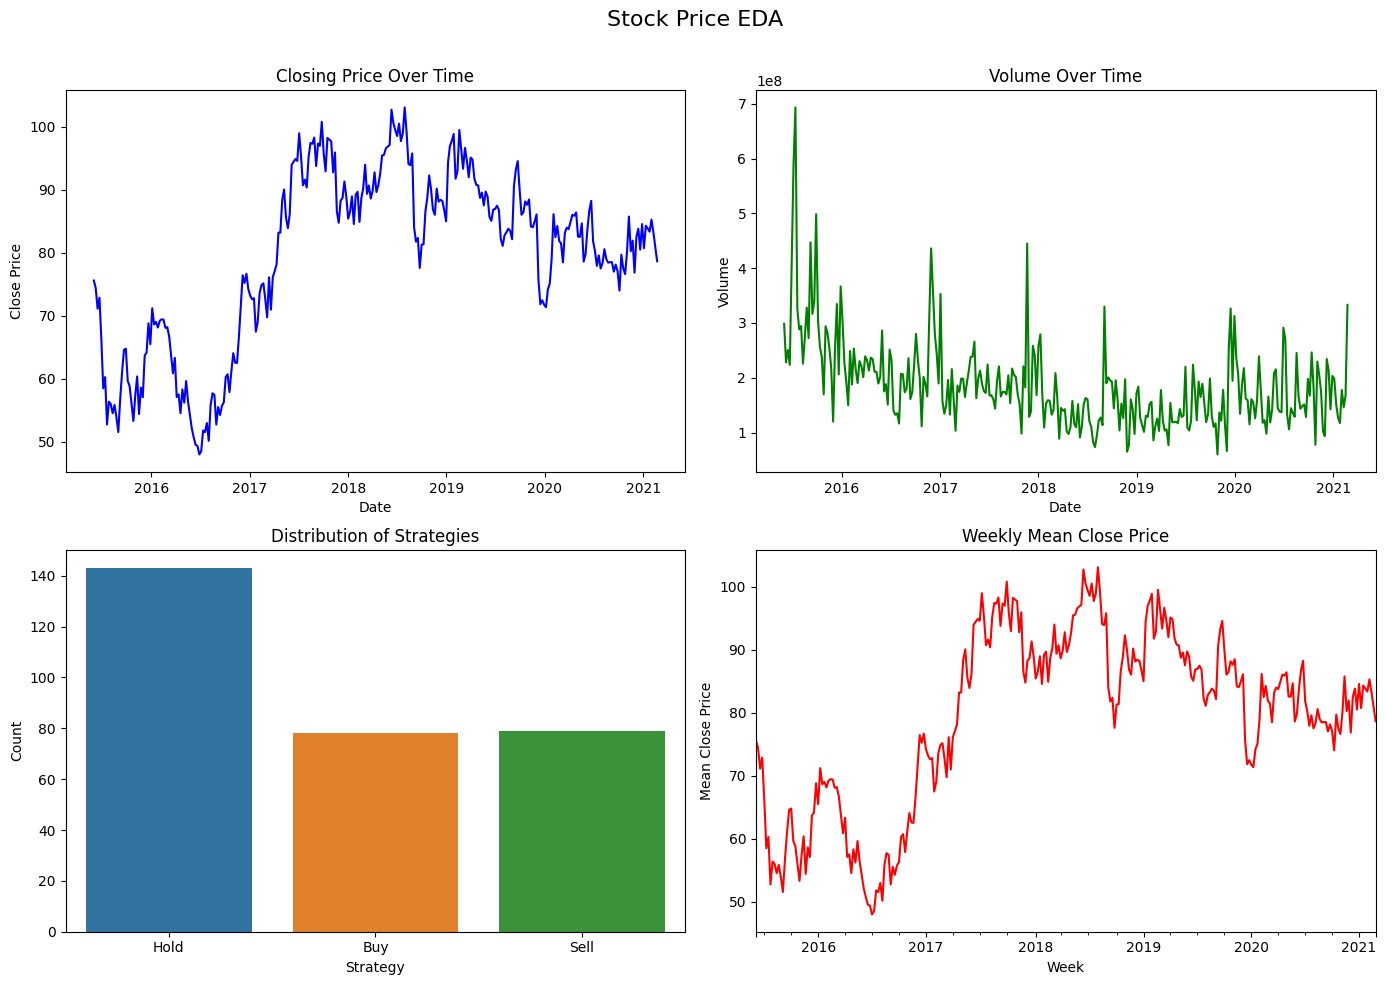

In [19]:
# Convert 'Date' column to datetime
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Set the date as the index for time series analysis
train_data.set_index('Date', inplace=True)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Stock Price EDA', fontsize=16)

# Plot 1: Closing Price over Time
axes[0, 0].plot(train_data.index, train_data['Close'], color='blue')
axes[0, 0].set_title('Closing Price Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Close Price')

# Plot 2: Volume over Time
axes[0, 1].plot(train_data.index, train_data['Volume'], color='green')
axes[0, 1].set_title('Volume Over Time')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volume')

# Plot 3: Strategy Distribution
sns.countplot(data=train_data, x='Strategy', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Strategies')
axes[1, 0].set_xlabel('Strategy')
axes[1, 0].set_ylabel('Count')

# Plot 4: Weekly Mean Close Price
weekly_mean = train_data['Close'].resample('W').mean()
weekly_mean.plot(ax=axes[1, 1], color='red')
axes[1, 1].set_title('Weekly Mean Close Price')
axes[1, 1].set_xlabel('Week')
axes[1, 1].set_ylabel('Mean Close Price')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### The provided charts offer an exploratory data analysis (EDA) of stock prices:

1. *Closing Price Over Time*: Shows fluctuations in stock prices from 2016 to 2021 with noticeable highs around 2018 and lows in 2016 and 2020.
2. *Volume Over Time*: Indicates the traded volume of the stock over the same period. There's a pronounced spike around 2017 and overall variability throughout the years.
3. *Distribution of Strategies*: Displays the frequency of trading strategies used. 'Hold' is the most frequently adopted strategy, followed by 'Buy' and 'Sell'.
4. *Weekly Mean Close Price*: Represents the average weekly closing prices of the stock, depicting a rise until 2018, followed by a decline and then stabilization. 

Overall, the stock experienced notable price changes over the years, with trading strategies predominantly favoring 'Hold'.

### 3.6 Trend Analysis

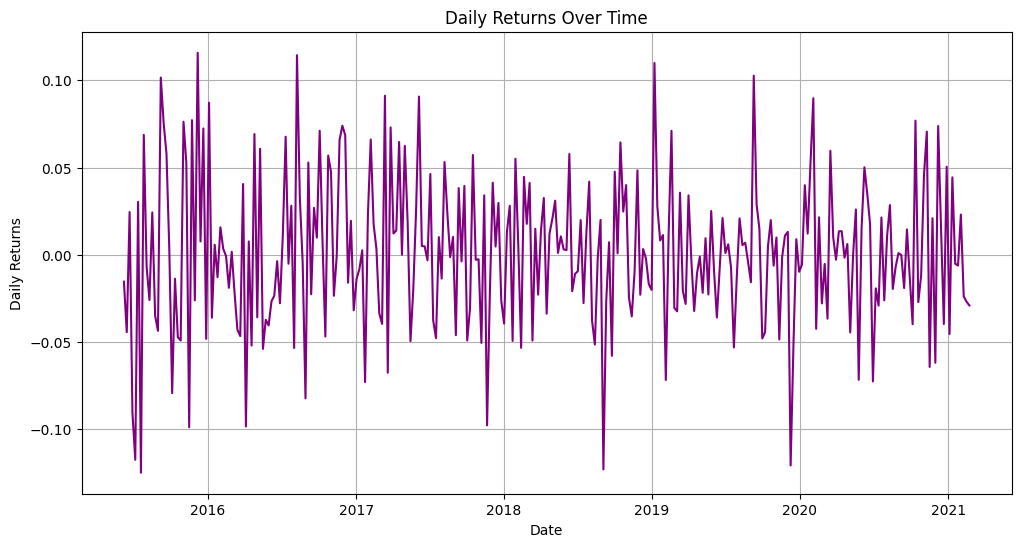

In [20]:
# Trend Analysis
# Calculate returns
train_data['Returns'] = train_data['Close'].pct_change()

# Visualize Returns
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Returns'], color='purple')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.grid()
plt.show()

#### The chart displays the daily returns of a stock from 2016 to 2021. The returns fluctuate frequently between positive and negative values, indicating volatility. Notably, there are several instances of sharp spikes and drops throughout the period, suggesting days with significant price changes. Overall, the stock has experienced consistent variability in its daily returns over the years.

### 3.7 Correlation Matrix

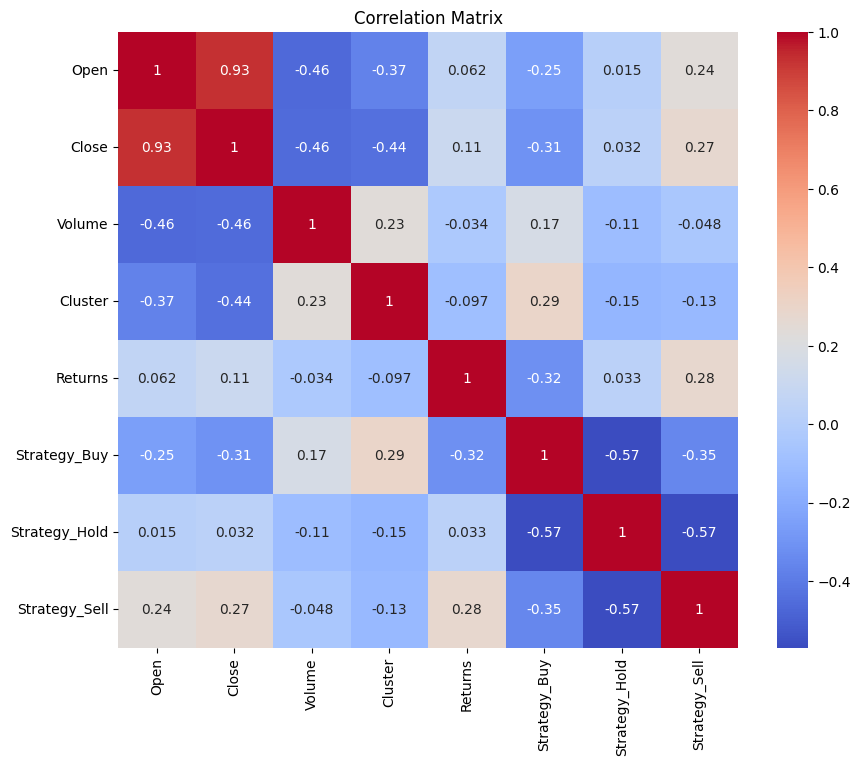

In [21]:
# One-hot encoding for the 'Strategy' column
train_data = pd.get_dummies(train_data, columns=['Strategy'])

# Calculate the correlation matrix
correlation_matrix = train_data.corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### The heatmap displays the correlation matrix for various metrics. Key observations:

1. "Open" and "Close" prices are highly correlated (0.93), indicating they often move together.
2. Both "Open" and "Close" prices have a negative correlation with "Volume" (around -0.46), suggesting that as prices increase, trading volume might decrease.
3. "Cluster" and "Volume" have a positive correlation of 0.23, implying some relation between clustering patterns and trading volume.
4. "Returns" exhibit low correlation with most other metrics, with the most negative correlation being with "Strategy_Buy" at -0.32.
5. Strategies "Buy", "Hold", and "Sell" have negative correlations among them, with "Buy" and "Hold" having the highest negative correlation (-0.57).

Overall, the matrix gives insights into how certain metrics relate to each other in the dataset.

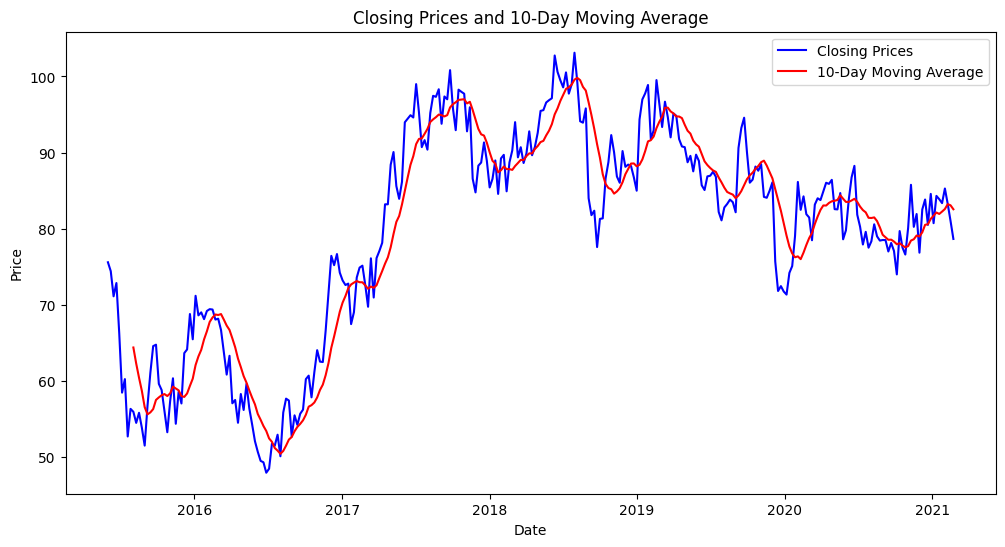

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (replace 'your_dataset.csv' with the actual file path)
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Calculate the 10-day moving average of the 'Close' column
data['10_Day_MA'] = data['Close'].rolling(window=10).mean()

# Create a line chart to visualize the closing prices and moving average
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Closing Prices', color='blue')
plt.plot(data['Date'], data['10_Day_MA'], label='10-Day Moving Average', color='red')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Prices and 10-Day Moving Average')
plt.legend()

# Show the plot
plt.show()


#### The graph displays the closing prices of an asset over time from 2016 to 2021. Additionally, a 10-day moving average is plotted. The asset experienced notable fluctuations, with a peak around late 2017 or early 2018. After this peak, there was a decline followed by stabilization. The 10-day moving average generally follows the trend of the closing prices, smoothing out short-term fluctuations.

## 4. ARIMA Model

### 4.1 Checking if data is stationary -> Dickey Fuller Test

In [23]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    print(dfoutput)

    if dfoutput['p-value'] <= 0.05:
        print("\nStationary!")
    else:
        print("\nNot Stationary!")

check_stationarity(train_data['Close'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.808006
p-value                          0.376494
#Lags Used                       1.000000
Number of Observations Used    298.000000
Critical Value (1%)             -3.452486
Critical Value (5%)             -2.871288
Critical Value (10%)            -2.571964
dtype: float64

Not Stationary!


#### The Dickey-Fuller test results indicate that the data is not stationary, as the test statistic (-1.808006) is greater than the critical values at all confidence levels (1%, 5%, 10%) and the p-value (0.376494) is greater than common significance levels.

### 4.2 Differencing to make it stationary

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA  # Updated import

# Load your dataset (replace 'your_dataset.csv' with the actual file path)
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Differencing to make the data stationary
data['Close_diff'] = data['Close'].diff().dropna()


### 4.3 ACF and PACF plots

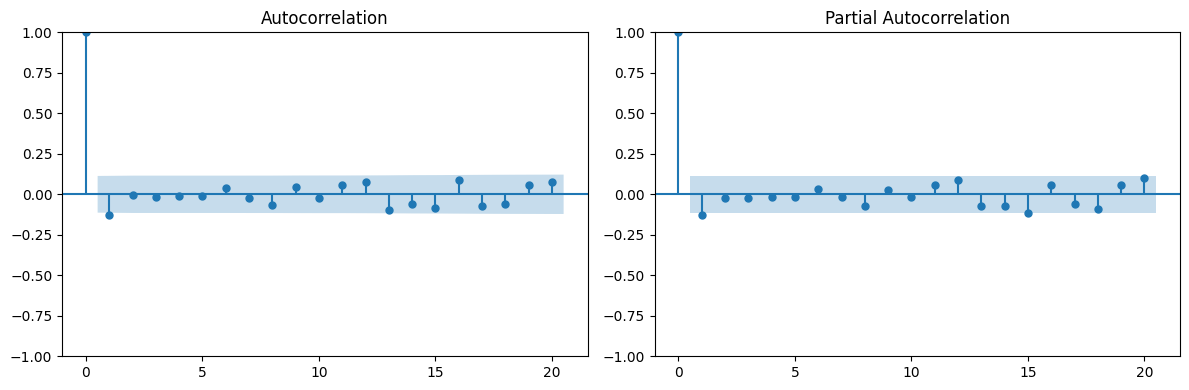

In [25]:
data_diff = data['Close'].diff().dropna()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data_diff, ax=ax[0], lags=20)
plot_pacf(data_diff, ax=ax[1], lags=20)
plt.tight_layout()
plt.show()

#### The autocorrelation plot shows a significant spike at lag 1 and then declines towards zero for subsequent lags. The partial autocorrelation plot also has a significant spike at lag 1 but drops off sharply afterwards. This suggests that the data may be best described using an AR(1) model, as there's a strong autocorrelation at the first lag and minimal correlations thereafter.

### 4.4 Training ARIMA Model

In [26]:
# Assuming data is a DataFrame with a DateTimeIndex
data.index.freq = 'W-MON'  # Set the frequency to daily

# Choose p and q values based on ACF and PACF plots
p, d, q = 1, 1, 1  # Example values, adjust as needed

# Train the ARIMA model
model = ARIMA(data['Close'], order=(p, d, q))
model_fit = model.fit()

# Forecast future stock prices
# Forecast future stock prices
forecast_steps = 10  # Number of time steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)
forecast

2021-03-01    79.088733
2021-03-08    79.150514
2021-03-15    79.159673
2021-03-22    79.161031
2021-03-29    79.161232
2021-04-05    79.161262
2021-04-12    79.161267
2021-04-19    79.161267
2021-04-26    79.161267
2021-05-03    79.161267
Freq: W-MON, Name: predicted_mean, dtype: float64

In [27]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [28]:
# train_ar = data['Open'].values
# test_ar = data['Open'].values

# history = [x for x in train_ar]
# print(type(history))
# predictions = list()
# for t in range(len(test_ar)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test_ar[t]
#     history.append(obs)
#     #print('predicted=%f, expected=%f' % (yhat, obs))
# error = mean_squared_error(test_ar, predictions)
# print('Testing Mean Squared Error: %.3f' % error)
# error2 = smape_kun(test_ar, predictions)
# print('Symmetric mean absolute percentage error: %.3f' % error2)


#### <class 'list'>, Testing Mean Squared Error: 14.684, Symmetric mean absolute percentage error: 4.122

#### Arima gives SATISFACTORY results but linear regression gives better results.

## 5. Linear Regression Model

### 5.1 Loading Libraries

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the training data
train_data = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")

### 5.2 Feature Engineering

In [30]:
# 1. Lag features for 'Open' prices
train_data['Open_Lag1'] = train_data['Open'].shift(1)
train_data['Open_Lag2'] = train_data['Open'].shift(2)

# 2. Rolling statistics (e.g., 5-day moving average) for 'Volume'
train_data['Rolling_Volume_Mean'] = train_data['Volume'].rolling(window=5).mean()
train_data['Rolling_Volume_Std'] = train_data['Volume'].rolling(window=5).std()

# Add more lag features
train_data['Open_Lag3'] = train_data['Open'].shift(3)
train_data['Open_Lag4'] = train_data['Open'].shift(4)

### 5.3 Data Preprocessing

In [31]:
X = train_data[['Open', 'Volume', 'Open_Lag1', 'Open_Lag2', 'Rolling_Volume_Mean', 'Rolling_Volume_Std','Open_Lag3','Open_Lag4']]
y_close = train_data['Close']

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can choose a different strategy based on your data
X = imputer.fit_transform(X)

# Split the data into training and validation sets
X_train, X_valid, y_close_train, y_close_valid = train_test_split(
    X, y_close, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

### 5.4 Training LR Model

In [32]:
# Train a Linear Regressor to predict 'Close' prices
close_model = LinearRegression()
close_model.fit(X_train, y_close_train)

# Make predictions on the validation set
close_preds = close_model.predict(X_valid)

### 5.5 Evaluation

In [33]:
# Evaluate the model
mae = mean_absolute_error(y_close_valid, close_preds)

print(f"Mean Absolute Error for Close Price Prediction: {mae}")

Mean Absolute Error for Close Price Prediction: 1.5995838092700714


### 5.6 Applying on test data

In [34]:
# Load the test data
test_data = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")

# Feature engineering for the test data (similar to the training data)
test_data['Open_Lag1'] = test_data['Open'].shift(1)
test_data['Open_Lag2'] = test_data['Open'].shift(2)
test_data['Rolling_Volume_Mean'] = test_data['Volume'].rolling(window=5).mean()
test_data['Rolling_Volume_Std'] = test_data['Volume'].rolling(window=5).std()
test_data['Open_Lag3'] = test_data['Open'].shift(3)
test_data['Open_Lag4'] = test_data['Open'].shift(4)
# Select the same features as used in the training data
X_test = test_data[['Open', 'Volume', 'Open_Lag1', 'Open_Lag2', 'Rolling_Volume_Mean', 'Rolling_Volume_Std','Open_Lag3','Open_Lag4']]

# Impute missing values in the test data
X_test = imputer.transform(X_test)

# Normalize test data
X_test = scaler.transform(X_test)

# Make predictions on the test data
test_close_preds = close_model.predict(X_test)

# Add the predictions to the test data
test_data['Close'] = test_close_preds
columns_to_drop = ['Open_Lag1','Open_Lag2','Rolling_Volume_Mean','Rolling_Volume_Std','Open_Lag3','Open_Lag4']
test_data = test_data.drop(columns=columns_to_drop)
test_data.to_csv('test.csv',index=False)

### 5.7 Hyperparameter Tuning -> Grid Search

In [35]:
# import pandas as pd
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.metrics import mean_absolute_error

# # Load the training data
# train_data = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")

# # Data preprocessing and feature engineering (same as in your code)
# # Split the data into training and validation sets
# X_train, X_valid, y_close_train, y_close_valid = train_test_split(
#     X, y_close, test_size=0.2, random_state=42)

# # Define the model
# lr = LinearRegression()

# # Define a parameter grid to search for the best hyperparameters
# param_grid = {
#     'fit_intercept': [True, False],  # Whether to calculate the intercept
#     'n_jobs': [None, -1],  # Number of CPU cores to use for computation
#     'positive': [True, False],  # Constrain the coefficients to be positive
# }

# # Create a GridSearchCV object
# grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='neg_mean_absolute_error')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_close_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Create a Linear Regression model with the best hyperparameters
# best_lr = LinearRegression(**best_params)

# # Train the model
# best_lr.fit(X_train, y_close_train)

# # Make predictions on the validation set
# close_preds = best_lr.predict(X_valid)

# # Evaluate the model
# mae = mean_absolute_error(y_close_valid, close_preds)

# print(f"Mean Absolute Error for Close Price Prediction: {mae}")

### 5.8 Test data output

In [36]:
data  = pd.read_csv("/kaggle/working/test.csv")
print(data.head())

   id        Date       Open     Volume      Close
0   0  2021-03-01  72.708331  205897600  79.323597
1   1  2021-03-08  73.310886  214095600  79.224478
2   2  2021-03-15  70.610119  151601700  78.982273
3   3  2021-03-22  70.256017  193982500  77.142385
4   4  2021-03-29  68.258324  220238400  76.620517


## 6. Ensemble Learning with XGBoost

### 6.1 Importing 

In [37]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

# Encode the 'Strategy' column into numerical labels
label_encoder = LabelEncoder()
data['Strategy_encoded'] = label_encoder.fit_transform(data['Strategy'])

### 6.2 Feature Engineering

In [38]:
n_lags = 10
for lag in range(1, n_lags + 1):
    data[f'Open_Lag_{lag}'] = data['Open'].shift(lag)
    data[f'Close_Lag_{lag}'] = data['Close'].shift(lag)
    data[f'Volume_Lag_{lag}'] = data['Volume'].shift(lag)

# Calculate MACD (12, 26, 9) - Example parameters, you can adjust them
short_period = 12
long_period = 26
signal_period = 9

data['EMA_12'] = data['Close'].ewm(span=short_period, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=long_period, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=signal_period, adjust=False).mean()

# Calculate RSI for a 14-day period
period = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=period).mean()
average_loss = loss.rolling(window=period).mean()
rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))
data['RSI'] = rsi

# Additional Features
n_sma = 20
data['SMA_Close'] = data['Close'].rolling(window=n_sma).mean()

# Define features and target
features = ['Open', 'Close', 'Volume'] + [f'Open_Lag_{lag}' for lag in range(1, n_lags + 1)] + \
           [f'Close_Lag_{lag}' for lag in range(1, n_lags + 1)] + [f'Volume_Lag_{lag}' for lag in range(1, n_lags + 1)] + ['SMA_Close', 'MACD', 'Signal_Line', 'RSI']

X = data[features]
y = data['Strategy_encoded']

# Handle missing values using an imputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Define individual models
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)

### 6.3 Making the Model

In [39]:
# Create an ensemble model using a VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('XGBoost', xgb_model)
], voting='soft')
# Split the data into training and testing sets
X_train = X
y_train = y

# Train the ensemble model on the entire dataset
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...))],
                 voting='soft')

### 6.4 Applying on test data

In [40]:
# Load your test dataset (replace 'test.csv' with the file path to your test data)
test_data = pd.read_csv('/kaggle/working/test.csv')

# Perform the same feature engineering and preprocessing on the test dataset
n_lags = 10
for lag in range(1, n_lags + 1):
    test_data[f'Open_Lag_{lag}'] = test_data['Open'].shift(lag)
    test_data[f'Close_Lag_{lag}'] = test_data['Close'].shift(lag)
    test_data[f'Volume_Lag_{lag}'] = test_data['Volume'].shift(lag)

# Calculate MACD (12, 26, 9) - Example parameters, you can adjust them
short_period = 12
long_period = 26
signal_period = 9

test_data['EMA_12'] = test_data['Close'].ewm(span=short_period, adjust=False).mean()
test_data['EMA_26'] = test_data['Close'].ewm(span=long_period, adjust=False).mean()
test_data['MACD'] = test_data['EMA_12'] - test_data['EMA_26']
test_data['Signal_Line'] = test_data['MACD'].ewm(span=signal_period, adjust=False).mean()

# Calculate RSI for a 14-day period
period = 14
delta = test_data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=period).mean()
average_loss = loss.rolling(window=period).mean()
rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))
test_data['RSI'] = rsi

# Additional Features

n_sma = 20
test_data['SMA_Close'] = test_data['Close'].rolling(window=n_sma).mean()

# Define features for the test dataset
test_features = ['Open', 'Close', 'Volume'] + [f'Open_Lag_{lag}' for lag in range(1, n_lags + 1)] + \
                [f'Close_Lag_{lag}' for lag in range(1, n_lags + 1)] + [f'Volume_Lag_{lag}' for lag in range(1, n_lags + 1)] + ['SMA_Close', 'MACD', 'Signal_Line', 'RSI']

# Handle missing values in the test dataset using the same imputer
test_X = test_data[test_features]
test_X = imputer.transform(test_X)

# Predict 'Strategy' labels on the test dataset
test_predictions = ensemble_model.predict(test_X)

# Decode the numerical labels back to the original 'Strategy' labels
test_predictions = label_encoder.inverse_transform(test_predictions)

# Add the predicted 'Strategy' labels to the test dataset
test_data['Strategy'] = test_predictions


### 6.5 HyperParameter Tuning -> Grid Search

In [41]:
# # Define hyperparameters to search over
# param_grid = {
#     'XGBoost__n_estimators': [100, 200, 300],
#     'XGBoost__max_depth': [3, 4, 5],
#     'XGBoost__learning_rate': [0.05, 0.1, 0.2]
# }

# # Create a grid search object
# grid_search = GridSearchCV(ensemble_model, param_grid, cv=5, scoring='accuracy')

# # Fit the grid search to your data
# grid_search.fit(X, y)

# # Get the best hyperparameters from the grid search
# best_params = grid_search.best_params_

# # Print the best hyperparameters
# print("Best Hyperparameters:", best_params)

In [42]:
test_predictions

array(['Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy',
       'Hold', 'Buy', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell',
       'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell',
       'Sell', 'Sell', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Sell',
       'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell',
       'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Buy', 'Buy', 'Hold',
       'Hold', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Hold', 'Hold'],
      dtype=object)

In [43]:
selected_columns = test_data[['id',"Date","Close","Strategy"]]

selected_columns.to_csv('submission.csv', index=False)
selected_columns

,id,Date,Close,Strategy
0,0,2021-03-01,79.323597,Hold
1,1,2021-03-08,79.224478,Hold
2,2,2021-03-15,78.982273,Hold
3,3,2021-03-22,77.142385,Hold
4,4,2021-03-29,76.620517,Hold
...,...,...,...,...
95,95,2022-12-26,64.629792,Hold
96,96,2023-01-02,64.175998,Hold
97,97,2023-01-09,62.570091,Buy
98,98,2023-01-16,63.221223,Hold
